# Notebook A: Meme Image Selector with OpenCLIP 🖼️

In this notebook, you'll take your meme **captions** from the previous notebook, select one of them, and use it to semantically search a pool of 35 preloaded images.

You'll use OpenCLIP (an open-source model trained to match images to text) to:
- Embed your caption
- Compare it to image embeddings
- Rank the most relevant images
- Visualize the top 3 results

> Learn more about OpenCLIP here: https://github.com/mlfoundations/open_clip
"CLIP" stands for Contrastive Language-Image Pre-training, and OpenCLIP is an open-source alternative
to OpenAI's CLIP model. 

This notebook sets you up to later combine the image + caption into a final meme.

In [1]:
# Environment Setup
# 🛠️ Install required libraries
# These libraries are required for the code to run. We are going to use "pip" to install them.

!pip install -q \
  open_clip_torch \
  torchvision \
  ftfy \
  regex \
  tqdm \
  matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Imports and Model Setup
# Now we are going to import the required libraries and set up the model.
# We are going to use the "open_clip" library to load the CLIP model.

import os
import torch
import open_clip
from PIL import Image
from pathlib import Path
from torchvision import transforms
from tqdm import tqdm

## 1. Load OpenCLIP: model (ViT-B-32)
This model has been trained on a dataset of **34 billion** image<>caption pairs, and has a 72.8% zero-shot accuracy. 

In the cell below you'll load and assign the model to variable `model`. 

In [3]:
# Load OpenCLIP model (ViT-B-32 for speed, pre-trained on LAION-2B)

model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="laion2b_s34b_b79k")
tokenizer = open_clip.get_tokenizer("ViT-B-32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

## 2. Getting started with image search: 🔎
Now we are going to load the images that we want to use for the lab.
 - We are going to use the "Path" library to load the images from the directory.

The "glob" method to load all the images from the directory, and we're using the "assert" method to check if the images are loaded correctly - this is an example of error handling within Python. 

In [4]:
# We are going to use the "Path" library to load the images from the directory.

data_dir = Path("../images")  # 35 preloaded images for lab
image_paths = list(data_dir.glob("*.jpg")) + list(data_dir.glob("*.png"))
assert len(image_paths) >= 1, "No images found in image directory."

## 3. Create a function to view the selected images in the notebook

For this task, we'll use a popular Python libray in both machine learning and data science: `matplotlib`. 
You can think of it as a set of tools that allow you to visualize and create graphs and images of data. In this case, our data are the images returned by our `model`. 

We're using  `f string` to format (and later print) the `score` of each image returned. This score represents the model's confidence that image is a good match, based on the input. This is commonly coded as: `f"string {expression}"`

In [5]:
# Helper Function:  Display top matches
import matplotlib.pyplot as plt

def show_images(image_scores, top_k=3):
    top_images = sorted(image_scores, key=lambda x: x[1], reverse=True)[:top_k]
    fig, axes = plt.subplots(1, top_k, figsize=(5 * top_k, 5))
    if top_k == 1:
        axes = [axes]
    for ax, (img_path, score) in zip(axes, top_images):
        ax.imshow(Image.open(img_path))
        ax.set_title(f"Score: {score:.2f}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

## 4. Running an image search based on your inputs: 

**A look under the hood:** 
This is the core of the semantic image search loop.

Here's what happens:
1. Your input `caption` is turned into a vector (embedding) using OpenCLIP’s text encoder.
2. Each image in the dataset is processed and converted to its own image embedding.
3. The code calculates the similarity between the caption and each image using dot-product (cosine similarity under normalization).
4. Each score tells us how well that image matches the meaning of your caption.
5. We save those (image path, score) pairs to rank them later.

Everything is done inside a `with torch.no_grad()` block so it runs efficiently and avoids memory buildup on GPU (if used).

You can change the `caption` below to try new meme ideas and test the image retrieval accuracy as part of our testing.

100%|██████████| 35/35 [00:02<00:00, 16.47it/s]


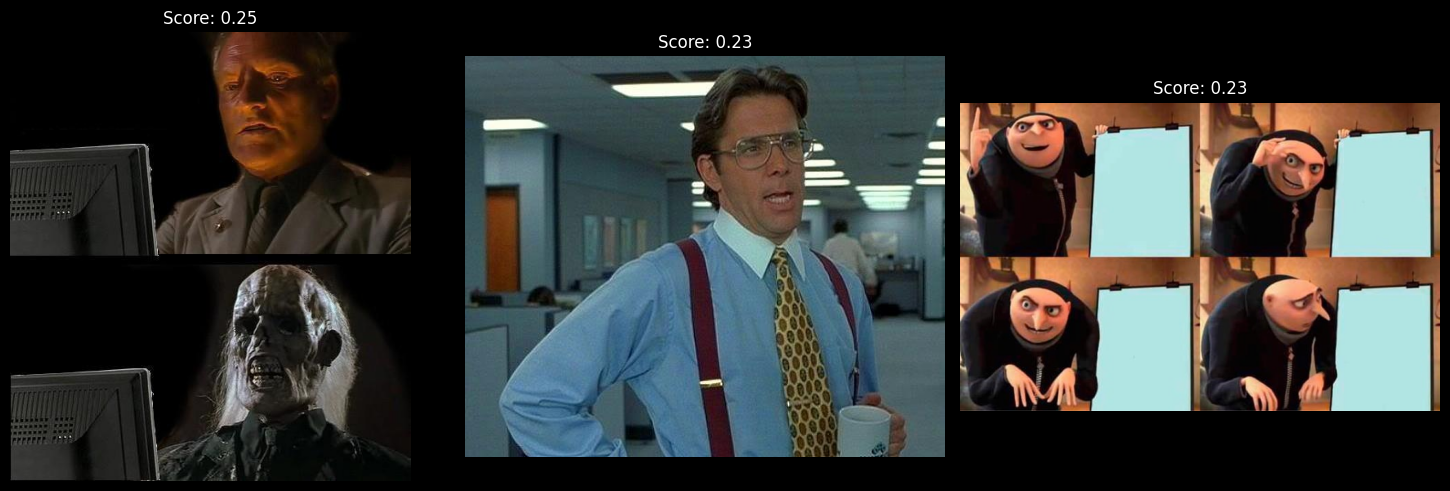

In [11]:
# Example Search: Static Caption
# This is an example search that shows the top 3 images based on a static caption. It does not save the results for the next step.

# Run a search based on text caption: 

caption = "Trying to stay awake in class but the professor’s voice is a lullaby"

with torch.no_grad():
    text_tokens = tokenizer([caption]).to(device)
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    image_scores = []
    for img_path in tqdm(image_paths):
        image = preprocess(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        similarity = (text_features @ image_features.T).item()
        image_scores.append((img_path, similarity))

# Show the top matches using the show_images function from above:
# We're going to return the top 3 matches based on the similarity score.
show_images(image_scores, top_k=3)

## 5. Run an image earch based on the caption you generated earlier: 
We are going to reference the `captions.json` created in the last notebook within this lab. 

This version lets you reuse captions generated earlier by loading them from a saved JSON file.
Make sure `captions.json` exists (created from the previous `1_meme_generator_inst.ipynb` notebook.

> If your captions.json is empty or showing captions different from your last run, go back to the first notebook, restart your kernel, and re run the cells to refresh the data. 

In [6]:
import json
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load captions.json generated in earlier notebook
captions_file = Path("../captions.json")
assert captions_file.exists(), "captions.json not found. Run the Instructor Notebook to generate it first."

with open(captions_file, "r") as f:
    caption_options = json.load(f)

caption_dropdown = widgets.Dropdown(
    options=caption_options,
    description='Caption:',
    layout=widgets.Layout(width='100%')
)

run_button = widgets.Button(description="Search Images")
output = widgets.Output()

def on_click(b):
    output.clear_output()
    with output:
        caption = caption_dropdown.value
        print(f"🔎 Searching for: {caption}")

        # Save the selected caption to ../selected_caption.json for use in Notebook B
        with open("../selected_caption.json", "w") as f:
            json.dump(caption, f)
        print(f"✅ Selected caption saved to '../selected_caption.json': {caption}") # We'll use this .json file in the next notebook

        with torch.no_grad():
            text_tokens = tokenizer([caption]).to(device)
            text_features = model.encode_text(text_tokens)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            image_scores = []
            for img_path in tqdm(image_paths):
                image = preprocess(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)
                image_features = model.encode_image(image)
                image_features /= image_features.norm(dim=-1, keepdim=True)

                similarity = (text_features @ image_features.T).item()
                image_scores.append((img_path, similarity))

        show_images(image_scores, top_k=3)

        # Sort and save top 3 images for next cell
        image_scores_sorted = sorted(image_scores, key=lambda x: x[1], reverse=True)
        top_image_paths = [str(path) for path, _ in image_scores_sorted[:3]]

        with open("../top_images.json", "w") as f:
            json.dump(top_image_paths, f)

        print("✅ Top 3 image paths saved to '../top_images.json' for selection in the next cell.")

run_button.on_click(on_click)
display(caption_dropdown, run_button, output)

Dropdown(description='Caption:', layout=Layout(width='100%'), options=("As it turns out,'students should be aw…

Button(description='Search Images', style=ButtonStyle())

Output()

## 6. Select the image for your meme from results

The cell bewlo lets you select the final image from the top 3 matches and prepares it for use in the final meme.
You'll choose one of the top image paths to pair with your caption selected from earlier.

Run the cell below to select your image.

**How to Use This Cell**:
- Below, you'll see the 3 best image matches based on your selected meme text.
- Each image has a **'Select This Image'** button beneath it.
- Click the button under the image you like the most.


Your selection will be saved to `../selected_image.json` for the next part of the lab.

In [ ]:
"""
This cell lets you select the final image from the top 3 matches by clicking on the image.
Your selection will be saved for use in the final meme.
Works in Jupyter, Colab, and VSCode.
"""

from IPython.display import display
import ipywidgets as widgets
import json
from PIL import Image
from io import BytesIO
import base64

# Load top 3 image paths from generated JSON (instead of static list)
with open("../top_images.json", "r") as f:
    top_image_paths = json.load(f)

# Prepare image widgets
def image_to_widget(img_path):
    img = Image.open(img_path).convert("RGB")
    buffer = BytesIO()
    img.thumbnail((400, 400))
    img.save(buffer, format="JPEG")
    encoded = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return widgets.HTML(f'<img src="data:image/jpeg;base64,{encoded}" style="border:2px solid black; margin:5px;">')

# Display images with buttons
output = widgets.Output()

selected_image = None

def on_button_click(img_path):
    global selected_image
    selected_image = img_path
    with output:
        output.clear_output()
        print(f"✅ You selected: {img_path}")
        with open("../selected_image.json", "w") as f:
            json.dump(selected_image, f)
        print("Saved selection to '../selected_image.json'.")

for img_path in top_image_paths:
    img_widget = image_to_widget(img_path)
    button = widgets.Button(description="Select This Image", layout=widgets.Layout(width='auto'))
    button.on_click(lambda b, p=img_path: on_button_click(p))
    display(widgets.VBox([img_widget, button]))

display(output)

Output()


## 7. What Happens Next: 📝

Once you've selected an image, it will be saved for you.

You'll combine it with your chosen caption in the final lab step to create your meme!


## 8. Lab Complete: Image Ranking with OpenCLIP ✅

You’ve now tested text-to-image semantic matching using OpenCLIP! Congratulations! 

You've completed
- Entering a meme caption, loaded from your `captions.json` file.
- Performed a vector embedding and search of your caption text using OpenCLIP to return the top 3 images based on that caption.
- Displayed the scoring (confidence) of each image.
- Picked an image you want to pair with the caption - these are the building blocks of your AI-meme.

→You are now ready to integrate this into the a final product in the next notebook!